<a href="https://colab.research.google.com/github/stemgene/Predict-Stock-Price-by-LSTM-and-Twitter-Analysis-/blob/master/3_LSTM_on_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import csv
import time
import statistics

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
stocks = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/SP500_cleaned.csv", parse_dates=['Date']).set_index('Date')
df = stocks.copy()
df.head()

,price,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,FFT 3,FFT 6,FFT 9,ARIMA
Date,,,,,,,,,,,,,,,,
2016-11-01,2111.719971,4532160000,2111.719971,2111.719971,2111.719971,2111.719971,0.000000,40.901838,2193.523646,2029.916296,2111.719971,2110.719971,2615.7224,2584.3904,2564.2063,2111.719971
2016-11-02,2097.939941,4248580000,2097.939941,2097.939941,2104.564955,2104.255788,-0.309167,40.901838,2179.743616,2016.136266,2101.384949,2096.939941,2610.4692,2573.1755,2546.7517,2097.939941
2016-11-03,2088.659912,3886740000,2088.659912,2088.659912,2098.850428,2098.168714,-0.681714,40.901838,2170.463587,2006.856237,2092.575308,2087.659912,2605.2153,2561.9850,2529.3977,2088.659912
2016-11-04,2085.179932,3837860000,2085.179932,2085.179932,2095.028755,2094.068663,-0.960091,40.901838,2166.983607,2003.376257,2087.583429,2084.179932,2599.9626,2550.8303,2512.1785,2085.179932
2016-11-07,2131.520020,3736060000,2131.520020,2131.520020,2103.491230,2104.244063,0.752833,40.901838,2213.323695,2049.716345,2116.995527,2130.520020,2594.7124,2539.7214,2495.1277,2131.520020


In [23]:
from numpy import genfromtxt
X_train = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_train_522_5_39.csv', delimiter=',').reshape(522,5,39)
X_val = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_val_115_5_39.csv', delimiter=',').reshape(115,5,39)
X_test = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_test_113_5_39.csv', delimiter=',').reshape(113,5,39)
y_train = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_train.csv', delimiter=',').reshape(-1,1)
y_val = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_val.csv', delimiter=',').reshape(-1,1)
y_test = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_test.csv', delimiter=',').reshape(-1,1)
label_level_matrix = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/label_level_matrix.csv', delimiter=',')
print("X_train's shape:", X_train.shape)
print("y_train's shape:", y_train.shape)
print("X_val's shape:", X_val.shape)
print("y_val's shape:", y_val.shape)
print("X_test's shape:", X_test.shape)
print("y_test's shape:", y_test.shape)


X_train's shape: (522, 5, 39)
y_train's shape: (522, 1)
X_val's shape: (115, 5, 39)
y_val's shape: (115, 1)
X_test's shape: (113, 5, 39)
y_test's shape: (113, 1)


### Keras doesn't need validation set, it can split validation set in models itself

In [24]:
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)
print("X_train's shape:", X_train.shape)
print("y_train's shape:", y_train.shape)

X_train's shape: (637, 5, 39)
y_train's shape: (637, 1)


## Proform LSTM

### Build and train model

In [25]:
def build_model(layers):
  d = 0.10
  model = Sequential()

  model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
  model.add(Dropout(d))

  model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
  model.add(Dropout(d))

  model.add(Flatten())

  model.add(Dense(32, kernel_initializer='uniform', activation='elu'))
  model.add(Dense(1, kernel_initializer='uniform', activation='linear'))

  adam = keras.optimizers.Adam(decay=0.2)

  start = time.time()
  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
  print("Comilation Time:", time.time()-start)
  return model

window = 5
model = build_model([39, window, 1]) # 22 = number of features
model.fit(X_train, y_train, batch_size=512, epochs=90, validation_split=0.18, verbose=1)

Comilation Time: 0.02631235122680664
Train on 522 samples, validate on 115 samples
Epoch 1/90
522/522 [==============================] - 2s 4ms/step - loss: 0.3016 - acc: 0.0000e+00 - val_loss: 0.3876 - val_acc: 0.0000e+00
Epoch 2/90
522/522 [==============================] - 0s 823us/step - loss: 0.2287 - acc: 0.0000e+00 - val_loss: 0.2029 - val_acc: 0.0000e+00
Epoch 3/90
522/522 [==============================] - 0s 831us/step - loss: 0.1125 - acc: 0.0000e+00 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 4/90
522/522 [==============================] - 0s 822us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0477 - val_acc: 0.0000e+00
Epoch 5/90
522/522 [==============================] - 0s 826us/step - loss: 0.0656 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 6/90
522/522 [==============================] - 0s 803us/step - loss: 0.0155 - acc: 0.0000e+00 - val_loss: 0.0420 - val_acc: 0.0000e+00
Epoch 7/90
522/522 [==============================] - 0s 800us/step

## Predict and denormalize data

### Predict

In [0]:
diff = []
ratio = []
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
#print(p.shape)

#for each data index in test data
for u in range(len(y_test)):
  # pr = prediction day u
  pr = y_test_pred[u][0]
  # (y_test day u / pr) - 1
  ratio.append((y_test[u]/pr)-1)
  diff.append(abs(y_test[u]-pr))

#### Evaluate the model

In [27]:
def model_score(model, X_train, y_train, X_test, y_test):
  trainScore = model.evaluate(X_train, y_train, verbose=0)
  print("Train Score: %.5f MSE (%.2f RMSE)"%(trainScore[0], math.sqrt(trainScore[0])))

  testScore = model.evaluate(X_test, y_test, verbose=0)
  print("Test Score: %.5f MSE (%.2f RMSE)"%(testScore[0], math.sqrt(testScore[0])))
  return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00168 MSE (0.04 RMSE)
Test Score: 0.00411 MSE (0.06 RMSE)


(0.0016775772646595863, 0.0041077009080785565)

#### Denomalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler 
def denormalize(df_ori, normalized_value):
  ori_reshaped = df_ori.reshape(-1,1)
  normalized_value = normalized_value.reshape(-1, 1)

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(ori_reshaped)
  denormed = scaler.inverse_transform(normalized_value)
  return denormed.reshape(-1)

pred_normed = np.concatenate((y_train_pred, y_test_pred), axis=None)
pred_denorm = denormalize(label_level_matrix, pred_normed)

split train and test

In [0]:
true_price_train = df.price[window:window + y_train.shape[0]]
true_price_test = df.price[window+ y_train.shape[0]:window + y_train.shape[0]+y_test.shape[0]]
pred_price_train = pred_denorm[:y_train.shape[0]]
pred_price_test = pred_denorm[y_train.shape[0]:y_train.shape[0]+y_test.shape[0]]

#### Evaluate the model

Calculate RMSE

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# use true price to calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(true_price_train, pred_price_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(true_price_test, pred_price_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 39.39 RMSE
Test Score: 61.63 RMSE


Calculate R^2 and t-test

In [31]:
true_list = df.loc[:,'price'][window:].to_list()
pred_list = pred_denorm.tolist()
evaluate_df = pd.DataFrame({"true": true_list, "pred":pred_list})
evaluate_df.head()

,true,pred
0,2139.560059,2170.533203
1,2163.260010,2162.263428
2,2167.479980,2170.821533
3,2164.449951,2177.874756
4,2164.199951,2190.047363


In [0]:
evaluate_df.to_csv('evaluate_group4ke.csv')
!cp evaluate_group4ke.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/evaluate_group4ke.csv

For checking 

In [32]:
true_test_list = true_price_test.to_list()
pred_test_list = pred_price_test.tolist()
print(pred_test_list[0], true_test_list[0])

2877.6455078125 2822.23999


In [33]:
pred_train_list = pred_price_train.tolist()
pred_train_list

[2170.533203125,
 2162.263427734375,
 2170.821533203125,
 2177.874755859375,
 2190.04736328125,
 2190.460205078125,
 2184.91552734375,
 2189.3515625,
 2196.95751953125,
 2203.151611328125,
 2213.352783203125,
 2215.925048828125,
 2216.101806640625,
 2215.70556640625,
 2215.64599609375,
 2232.054443359375,
 2239.12353515625,
 2241.49609375,
 2228.966552734375,
 2226.501220703125,
 2216.33154296875,
 2206.6279296875,
 2210.22216796875,
 2210.5517578125,
 2212.55029296875,
 2221.92822265625,
 2248.74658203125,
 2258.8818359375,
 2257.3203125,
 2259.7392578125,
 2254.845947265625,
 2259.558349609375,
 2254.2646484375,
 2266.854736328125,
 2270.399658203125,
 2271.091796875,
 2270.4677734375,
 2271.248291015625,
 2265.7685546875,
 2268.234375,
 2275.634521484375,
 2268.833984375,
 2264.28564453125,
 2275.88818359375,
 2275.438232421875,
 2276.904541015625,
 2278.35791015625,
 2274.69921875,
 2280.602783203125,
 2284.568359375,
 2286.085693359375,
 2285.175537109375,
 2290.317626953125,
 228

In [34]:
label_level_matrix[:3]

array([2111.719971, 2097.939941, 2088.659912])

In [35]:
pred_denorm[y_train.shape[0]:y_train.shape[0]+y_test.shape[0]]

array([2877.6455, 2872.9565, 2872.038 , 2868.0781, 2857.1118, 2846.1465,
       2844.982 , 2827.8638, 2826.0042, 2819.94  , 2812.1367, 2808.4968,
       2818.6465, 2831.552 , 2855.1758, 2859.6536, 2867.7173, 2872.473 ,
       2870.6372, 2874.096 , 2882.222 , 2896.5706, 2903.7466, 2898.9866,
       2890.5493, 2894.8962, 2903.9592, 2902.1394, 2903.7522, 2904.1523,
       2911.9583, 2928.591 , 2935.7542, 2942.9216, 2941.1748, 2934.5715,
       2932.3738, 2943.9775, 2950.8271, 2950.7305, 2955.0117, 2952.4502,
       2955.245 , 2959.5574, 2967.4988, 2959.8481, 2959.5754, 2964.5356,
       2965.0183, 2968.0232, 2966.8074, 2955.81  , 2939.2664, 2924.3315,
       2915.92  , 2900.907 , 2904.2327, 2909.49  , 2912.606 , 2909.0913,
       2904.6897, 2900.9724, 2894.824 , 2901.943 , 2920.2053, 2918.8723,
       2909.5767, 2906.5037, 2896.6592, 2884.4846, 2886.9255, 2896.151 ,
       2903.0583, 2907.551 , 2910.3892, 2911.2654, 2922.3796, 2928.6697,
       2930.4167, 2930.7712, 2932.9546, 2939.1077, 

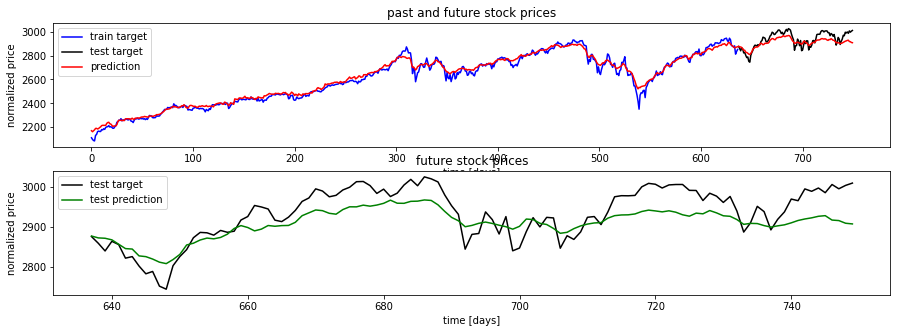

In [36]:
## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(2,1,1);

plt.plot(np.arange(X_train.shape[0]), df.price[:X_train.shape[0]], color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), df.price[y_train.shape[0]:y_train.shape[0]+y_test.shape[0]], color='black', label='test target')

plt.plot(np.arange(y_train.shape[0]+y_test.shape[0]), pred_denorm, color='red', label='prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(2,1,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), df.price[y_train.shape[0]:y_train.shape[0]+y_test.shape[0]], color='black', label='test target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), pred_denorm[y_train.shape[0]:y_train.shape[0]+y_test.shape[0]], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');



In [37]:
window = 5
se1 = np.full((window,), pred_denorm[0])
pred_denorm_fill = np.concatenate((se1, pred_denorm), axis=None) 
len(pred_denorm_fill)

755

In [0]:
df_plot = df.copy()
df_plot['Predicted Price'] = pred_denorm_fill

<Figure size 1600x1000 with 0 Axes>

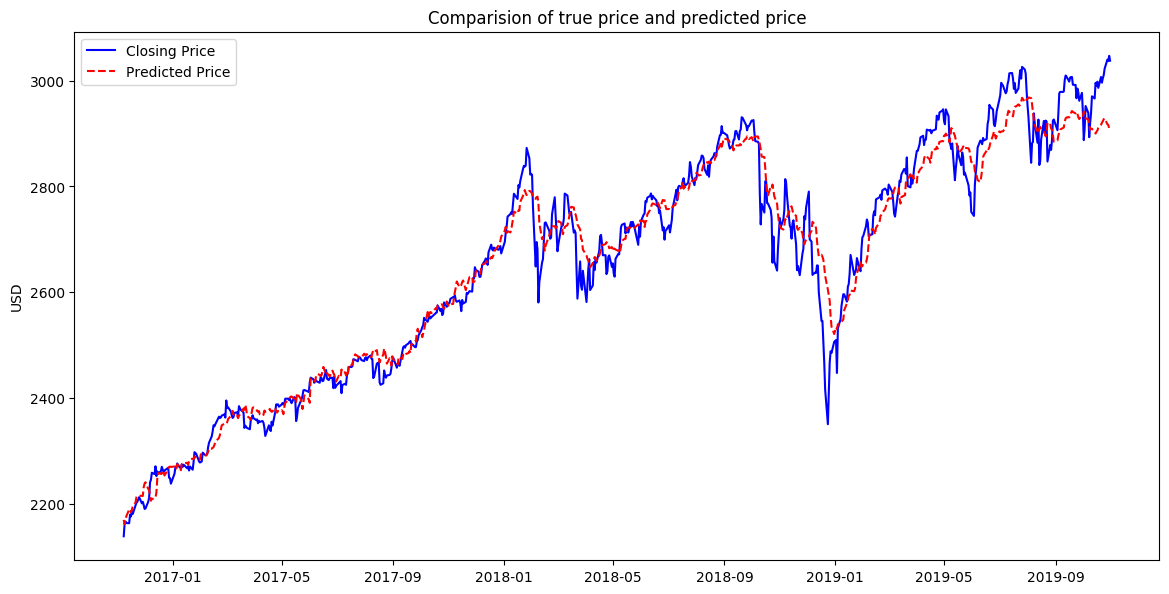

In [39]:
def plot_technical_indicators(dataset, pred_price):
    plt.figure(figsize=(16, 10), dpi=100)
    
#    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index[window:])
    
    # Plot first subplot
#    plt.subplot(2, 1, 1)
    plt.figure(figsize=(14, 7), dpi=100)
    plt.plot(dataset['price'][window:],label='Closing Price', color='b')
    plt.plot(x_, pred_price ,label='Predicted Price', color='r',linestyle='--')
    plt.title('Comparision of true price and predicted price')
    plt.ylabel('USD')
    plt.legend()

    # # Plot second subplot
    # plt.subplot(2, 1, 2)
    # plt.title('MACD')
    # plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

plot_technical_indicators(df, pred_denorm)

## Funny thing-automatic stock exchange stragedy



*   Start with $10000
*   days = 110 (length of test set)
*   buy if rise, sell if fall
*   increase mean and decrease mean, if exceed mean buy or sell 5%, otherwise 2.5%
*   if capital or stock is empty, wait for the next action.



In [0]:
class Auto_exchange():
  def __init__(self):
    self.capital = 10000
    self.remain = 10000
    self.stock = 0
    self.avg = []
    self.small_rate = 0.025
    self.large_rate = 2 * self.small_rate
  def assestment(self):
    return print(self.remain + self.stock * self.true_value[-1] - self.capital)
  def trade(self, y_test, y_pred):
    self.days = len(y_pred)
    self.true_value = y_test
    self.pred_value = y_pred
    for day in range(1, self.days):
      self.diff = self.pred_value[day] - self.pred_value[day-1]
      self.avg.append(abs(self.diff))
      self.threshold = statistics.mean(self.avg)
      if self.diff < 0:
        self.remain, self.stock = self.sell(self.true_value[day], day)
      if self.diff >0:
        self.remain, self.stock = self.buy(self.true_value[day])
      if self.diff == 0:
        continue
      f"Today is the {day}th day, my remain is {self.remain}, my stock is {self.stock}, it worth ${self.stock * self.true_value[day]}."
    print("Complete trade")
  def sell(self, true_value, day):
    if self.stock > 0:
      if self.diff >= self.threshold:
        self.remain += self.stock * self.large_rate * true_value
        self.stock = self.stock * (1-self.large_rate)
      else:
        self.remain += self.stock * self.small_rate * true_value
        self.stock = self.stock + (1-self.small_rate)
    else:
      print("Today is day {}, I don't have enough stock".format(day))
    return self.remain, self.stock
  def buy(self, true_value):
    if self.remain >= true_value * self.large_rate:
      if self.diff >= self.threshold:
        self.stock += self.remain * self.large_rate / true_value
        self.remain = self.remain * (1-self.large_rate)
      else:
        self.stock += self.remain * self.small_rate / true_value
        self.remain = self.remain * (1-self.small_rate)
    else:
      print("I am out of money")
    return self.remain, self.stock
      


true_price = df.price[window + y_train.shape[0]:window + y_train.shape[0]+y_test.shape[0]]/100
pred_price = pred_denorm[y_train.shape[0]:y_train.shape[0]+y_test.shape[0]]/100
auto = Auto_exchange()
auto.trade(true_price, pred_price)
auto.assestment()

Today is day 1, I don't have enough stock
Today is day 2, I don't have enough stock
Today is day 3, I don't have enough stock
Today is day 4, I don't have enough stock
Today is day 5, I don't have enough stock
Today is day 6, I don't have enough stock
Today is day 7, I don't have enough stock
Today is day 8, I don't have enough stock
Today is day 9, I don't have enough stock
Today is day 10, I don't have enough stock
Today is day 11, I don't have enough stock
Today is day 12, I don't have enough stock
Today is day 13, I don't have enough stock
Today is day 14, I don't have enough stock
Today is day 15, I don't have enough stock
Today is day 16, I don't have enough stock
Complete trade
11636.382396990892
